In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import h5py
from mpl_toolkits import mplot3d

from cca.synth_data import embedded_lorenz_cross_cov_mats, oscillators_dynamics_mat, oscillators_cross_cov_mats, sample_oscillators
from cca import style

import cca.synth_data

In [35]:
def gen_heatmap(cross_cov_mats, N_theta=100):
    N_phi = N_theta
    theta = np.concatenate((np.linspace(0, np.pi*(1. - 1./N_theta), N_theta - 1), [np.pi]))
    phi = np.concatenate((np.linspace(0, np.pi*(1. - 1./N_phi), N_phi - 1), [np.pi]))
    
    heatmap = np.zeros((N_theta, N_phi))
    
    def pi_val(theta, phi):
        x = np.cos(phi)*np.sin(theta)
        y = np.sin(phi)*np.sin(theta)
        z = np.cos(theta)
        v = np.array([x, y, z]).reshape((3, 1))
        pi = cca.cov_util.calc_pi_from_cross_cov_mats(cross_cov_mats, proj=v)
        return pi
    
    for theta_idx in range(N_theta):
        for phi_idx in range(N_phi):
            pi = pi_val(theta[theta_idx], phi[phi_idx])
            heatmap[theta_idx, phi_idx] = pi
            
    return heatmap

def find_local_maxima(Z, tol=1e-8):
    peaks = []
    n_i, n_j = Z.shape
    for i in range(n_i):
        for j in range(n_j):
            val = Z[i, j]
            if i not in [0, n_i-1] and j not in [0, n_j-1]:
                #regular case
                patch = Z[i-1:i+2, j-1:j+2].flatten()
                if val > np.max(patch[:4]) + tol and val > np.max(patch[5:]) + tol:
                    peaks.append((i, j))
            """
            else:
                #literal edge case
                if i == 0:
                    if val > np.max(Z[1, :]) + tol:
                        peaks += [[0, j_prime] for j_prime in range(n_j)]
                elif i == n_i-1:
                    if val > np.max(Z[n_i-2, :]) + tol:
                        peaks += [[n_i-1, j_prime] for j_prime in range(n_j)]
                elif j == 0:
                    patch = np.concatenate((Z[i-1:i+2, n_j-1:n_j], Z[i-1:i+2, :2]), axis=1).flatten()
                    if val > np.max(patch[:4]) + tol and val > np.max(patch[5:]) + tol:
                        peaks.append([i, j])
                elif j == n_j-1:
                    patch = np.concatenate((Z[i-1:i+2, n_j-2:n_j], Z[i-1:i+2, 0:1]), axis=1).flatten()
                    if val > np.max(patch[:4]) + tol and val > np.max(patch[5:]) + tol:
                        peaks.append([i, j])
            """
    return peaks

def find_global_maxima(Z, local_maxima=None, tol=1e-8):
    if local_maxima is None:
        local_maxima = find_local_maxima_2d(Z)
    max_val = np.max( [Z[i,j] for (i,j) in local_maxima] )
    peaks = []
    for (i, j) in local_maxima:
        if np.abs(Z[i, j] - max_val) <= tol:
            peaks.append((i, j))
    return peaks


def cca_proj(cov_11, cov_12):
    w = scipy.linalg.eigvalsh(cov_11)
    min_eig = np.min(w)
    eps = 1e-8
    if min_eig < eps:
        cov_11 = cov_11 + np.eye(cov_11.shape[0])*(-min_eig + eps)
    cov_neg_sqrt = np.real(np.linalg.inv(scipy.linalg.sqrtm(cov_11)))
    to_svd = cov_neg_sqrt.dot(cov_12).dot(cov_neg_sqrt)
    U, s, Vt = scipy.linalg.svd(to_svd)
    V = Vt.T
    U = np.dot(cov_neg_sqrt, U)
    V = np.dot(cov_neg_sqrt, V)
    U /= np.sqrt(np.sum(U**2, axis=0))
    V /= np.sqrt(np.sum(V**2, axis=0))
    return U, V

def sfa_proj(cov_11, cov_12):
    w = scipy.linalg.eigvalsh(cov_11)
    min_eig = np.min(w)
    eps = 1e-8
    if min_eig < eps:
        print("HMM")
        cov_11 = cov_11 + np.eye(cov_11.shape[0])*(-min_eig + eps)
    cov_neg_sqrt = np.real(np.linalg.inv(scipy.linalg.sqrtm(cov_11)))
    cov_sym = cov_12 + cov_12.T
    to_pca = cov_neg_sqrt.dot(cov_sym).dot(cov_neg_sqrt)
    _, V = scipy.linalg.eigh(to_pca)
    V = V[:, ::-1]
    print("Here")
    V = np.dot(cov_neg_sqrt, V)
    return V

def pca_proj(cov):
    _, V = scipy.linalg.eigh(cov)
    V = V[:, ::-1]
    return V

def dca_proj(cov_11, cov_12, d, n_init=1):
    opt = ComplexityComponentsAnalysis(init="random")
    opt.cross_covs = np.array([cov_11, cov_12.T])
    opt.fit_projection(d=d, n_init=n_init)
    V = opt.coef_
    return V

def quad_mat(A, B, C, D):
    top = np.concatenate((A, B), axis=1)
    bottom = np.concatenate((C, D), axis=1)
    mat = np.concatenate((top, bottom), axis=0)
    return mat

def calc_pi(cov_11, cov_12, U, V):
    proj_cov_11 = U.T.dot(cov_11).dot(U)
    proj_cov_22 = V.T.dot(cov_11).dot(V)
    proj_cov_12 = U.T.dot(cov_12).dot(V)
    proj_cov_21 = proj_cov_12.T
    cov_full = quad_mat(proj_cov_11, proj_cov_12, proj_cov_21, proj_cov_22)
    d1 = np.linalg.slogdet(proj_cov_11)[1]
    d2 = np.linalg.slogdet(proj_cov_22)[1]
    d3 = np.linalg.slogdet(cov_full)[1]
    return 0.5 * (d1 + d2 - d3) / np.log(2) #in BITS!

([<matplotlib.axes._axes.Axes at 0x7fd8726111d0>,
 <matplotlib.axes._axes.Axes at 0x7fd8703cc860>)

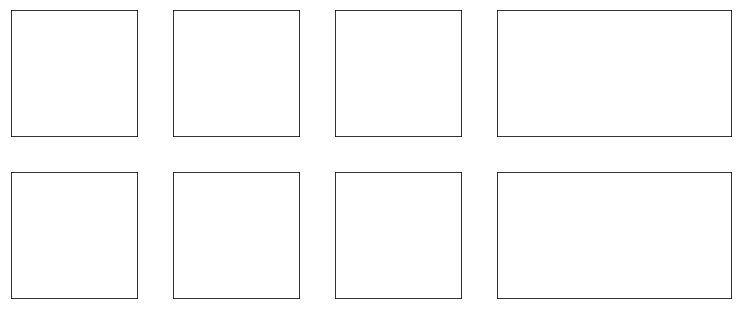

In [32]:
def make_axes(fig_width, n_sq=3, sq_width=0.175, wpad_edge=0, wpad_sq=0.05, wpad_mid=0.05, hpad_edge=0, hpad_mid=0.125):    
    sub_box_width = n_sq*sq_width + (n_sq - 1)*wpad_sq
    right_box_width = 1 - 2*wpad_edge - wpad_mid - sub_box_width
    sq_height = (1 - 2*hpad_edge - hpad_mid)/2
    fig_height = sq_width * fig_width / sq_height
    fig = plt.figure(figsize=(fig_width, fig_height))        
    
    top_squares, bottom_squares = [], []
    for i in range(n_sq):
        ax_top = fig.add_axes((wpad_edge + (sq_width + wpad_sq)*i, hpad_edge + sq_height + hpad_mid, sq_width, sq_height))
        ax_bottom = fig.add_axes((wpad_edge + (sq_width + wpad_sq)*i, hpad_edge, sq_width, sq_height))
        top_squares.append(ax_top)
        bottom_squares.append(ax_bottom)
        
    ax_right_top = fig.add_axes(( wpad_edge + sub_box_width + wpad_mid, hpad_edge, right_box_width, sq_height ))
    ax_right_bottom = fig.add_axes(( wpad_edge + sub_box_width + wpad_mid, hpad_edge + sq_height + hpad_mid, right_box_width, sq_height ))
    
    axes = top_squares + bottom_squares + [ax_right_top, ax_right_bottom]
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        
    return top_squares, bottom_squares, ax_right_top, ax_right_bottom
    
def disp_heatmap(ax, heatmap, show_xlabels=True, show_ylabels=True, title=None):
    N_theta, N_phi = heatmap.shape
    im = ax.imshow(heatmap, origin="lower left", cmap="gray", aspect='equal')
    
    local_maxima = find_local_maxima(heatmap)
    global_maxima = find_global_maxima(heatmap, local_maxima)
    non_global_maxima = list(set(local_maxima) - set(global_maxima))
    for pt in global_maxima:
        ax.scatter(pt[1], pt[0], c="red", marker="o", s=15)
    for pt in non_global_maxima:
        ax.scatter(pt[1], pt[0], edgecolors="red", marker="o", facecolors='none', s=15)
    
    if show_xlabels:
        ax.set_xlabel("$\phi$", fontsize=style.axis_label_fontsize, labelpad=-10)
        ax.set_xticks([0, N_phi-1])
        ax.set_xticklabels(["0", "$\pi$"], fontsize=style.ticklabel_fontsize)
    else:
        ax.set_xticks([])
    if show_ylabels:
        ax.set_ylabel("$\\theta$", fontsize=style.axis_label_fontsize, labelpad=-10)
        ax.set_yticks([0, N_theta-1])
        ax.set_yticklabels(["0", "$\pi$"], fontsize=style.ticklabel_fontsize)
    else:
        ax.set_yticks([])
    ax.set_xlim([0, heatmap.shape[1]-1])
    ax.set_ylim([0, heatmap.shape[0]-1])
    if title is not None:
        ax.set_title(title, fontsize=style.title_fontsize, pad=1)

make_axes(10, n_sq=3)

In [4]:
#get cross-cov mats for both systems
#Lorenz system (3d and high-d)
#lorenz_3d_cross_cov_mats = embedded_lorenz_cross_cov_mats(N=3, T=40, snr=1)
lorenz_highd_cross_cov_mats = embedded_lorenz_cross_cov_mats(N=30, T=11, snr=1)
#oscillator system (10 oscillators --> 20-dimensional state)
A = oscillators_dynamics_mat(N=10)
osc_cross_cov_mats = oscillators_cross_cov_mats(A, T=11)

(30, 27)


In [36]:
#run the 'MI vs. dim' analysis for both systems
lorenz_highd_cross_cov_mats[10] = 0.5*(lorenz_highd_cross_cov_mats[10] + lorenz_highd_cross_cov_mats[10].T)

cov_mats = (lorenz_highd_cross_cov_mats[[0, 10]], osc_cross_cov_mats[[0, 10], :, :])
lorenz_pi_vals = np.zeros((6, cov_mats[0].shape[1]))
osc_pi_vals = np.zeros((6, cov_mats[1].shape[1]))
pi_vals = (lorenz_pi_vals, osc_pi_vals)
for system_idx in range(len(cov_mats)):
    cov_11, cov_21 = cov_mats[system_idx]
    cov_12 = cov_21.T
    
    U_cca, V_cca = cca_proj(cov_11, cov_12)
    V_pca = pca_proj(cov_11)
    V_sfa = sfa_proj(cov_11, cov_12)
    V_trunc = np.eye(cov_11.shape[0])[:, ::-1]
    
    system_pi_vals = pi_vals[system_idx]
    N = len(system_pi_vals.T)
    
    for i in range(1, N+1):
        pi_cca = calc_pi(cov_11, cov_12, U_cca[:, :i], V_cca[:, :i])
        #V_dca = dca_proj(cov, cross_cov.T, i, n_init=1)
        pi_dca = 0.18 #calc_pi(cov_11, cov_12, V_dca, V_dca)
        pi_pca = calc_pi(cov_11, cov_12, V_pca[:, :i], V_pca[:, :i])
        pi_sfa = calc_pi(cov_11, cov_12, V_sfa[:, :i], V_sfa[:, :i])
        pi_trunc = calc_pi(cov_11, cov_12, V_trunc[:, :i], V_trunc[:, :i])
        pi_dumb_cca = calc_pi(cov_11, cov_12, U_cca[:, :i], U_cca[:, :i])
        system_pi_vals[:, i-1] = [pi_cca, pi_dca, pi_pca, pi_sfa, pi_trunc, pi_dumb_cca]


Here
Here


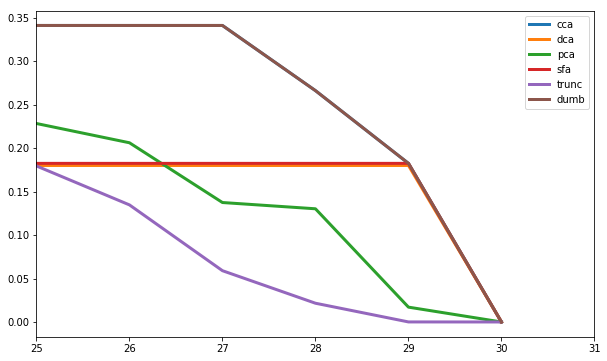

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(5*2, 3*2))

labels = ["cca", "dca", "pca", "sfa", "trunc", "dumb"]
for i in range(6):
    ax.plot(list(pi_vals[0][i, ::-1]) + [0], label=labels[i], linewidth=3)
ax.set_xlim([25, 31])
ax.legend()

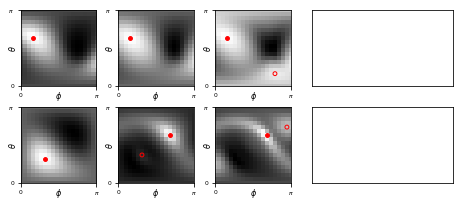

In [244]:
N_theta = 20

T_pi_vals = np.array([1, 5, 10])
top_squares, bottom_squares, ax_right_top, ax_right_bottom = make_axes(6, n_sq=len(T_pi_vals), sq_width=0.175)

#Find local minima and plot
for i in range(len(T_pi_vals)):
    T_pi = T_pi_vals[i]
    ax_top, ax_bottom = top_squares[i], bottom_squares[i]
    
    lorenz_heatmap = gen_heatmap(lorenz_cross_cov_mats[:2*T_pi], N_theta=N_theta)
    disp_heatmap(ax_top, lorenz_heatmap)
    
    osc_heatmap = gen_heatmap(osc_cross_cov_mats[:2*T_pi], N_theta=N_theta)
    disp_heatmap(ax_bottom, osc_heatmap)
    
#Make MI vs. dim curves
    
plt.savefig("figures/local_minima_test.pdf", bbox_inches="tight")
    

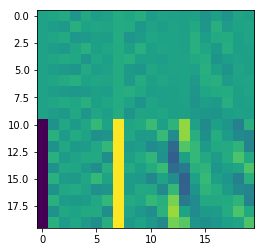

In [39]:
plt.imshow(V_sfa)